## Spotify Virtual User Environment and Contextual Bandit Music recommender

The objective of this notebook are two-fold:
1. (User.py) To use the Spotify dataset available on Kaggle for (Song features) https://www.kaggle.com/datasets/vatsalmavani/spotify-dataset?resource=download and (playlists) https://www.kaggle.com/datasets/andrewmvd/spotify-playlists/code  to create a 'virtual user'. A virtual user will mimic the real user, with a combination of static and dynamic features.
    Static features
    1. Gender
    2. Age
    3. Race
    4. Ethinicity
    5. Country
    6. State 
    7. Languages

    Dynamic Features
    1. Affinity towards a Genre
    2. Dynamic playlists
    3. Features of last $n$ played songs
    4. Time_of_the_day
2. (ContextualBandit.py) To build a recommender system using a contextual Bandit algorithm using a library called VowpalWabbit https://vowpalwabbit.org/docs/vowpal_wabbit/python/latest/tutorials/python_Contextual_bandits_and_Vowpal_Wabbit.html



In [1]:
#Libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
import vowpalwabbit
import random
import matplotlib.pyplot as plt
import pandas as pd
import itertools
from tqdm import tqdm
from ContextualBandit import ContextualBandit
from User import User

## Reading Datasets
There are two types of Spotify datasets that we are going to work with:
1. Spotify Song data base with features
2. Spotify User playlists


### Reading Spotify Songs data with features

In [4]:
data = pd.read_csv("./data/data.csv")
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           170653 non-null  float64
 1   year              170653 non-null  int64  
 2   acousticness      170653 non-null  float64
 3   artists           170653 non-null  object 
 4   danceability      170653 non-null  float64
 5   duration_ms       170653 non-null  int64  
 6   energy            170653 non-null  float64
 7   explicit          170653 non-null  int64  
 8   id                170653 non-null  object 
 9   instrumentalness  170653 non-null  float64
 10  key               170653 non-null  int64  
 11  liveness          170653 non-null  float64
 12  loudness          170653 non-null  float64
 13  mode              170653 non-null  int64  
 14  name              170653 non-null  object 
 15  popularity        170653 non-null  int64  
 16  release_date      17

In [5]:
data.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339
3,0.1650,1921,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.381,-9.316,1,Danny Boy,3,1921,0.0354,100.109
4,0.2530,1921,0.957,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.229,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665


In [6]:
## Keeping artist name as ',' sepearted only
data['artists'] = data['artists'].map(lambda x: x.lstrip('[').rstrip(']'))
#print(genre_data.info())
#print(year_data.info())

### Reading Playlist Dataset

In [7]:
df_playlist = pd.read_csv('data/archive/spotify_dataset.csv', error_bad_lines=False, warn_bad_lines=False,nrows=1600) #skiprows=lambda i: i>0 and random.random() > p)
df_playlist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   user_id          1600 non-null   object
 1    "artistname"    1599 non-null   object
 2    "trackname"     1600 non-null   object
 3    "playlistname"  1600 non-null   object
dtypes: object(4)
memory usage: 50.1+ KB


In [8]:
## Triming columns names
df_playlist=df_playlist.rename(columns={' "artistname"':'artistname',' "trackname"':'trackname',' "playlistname"':'playlistname'})
df_playlist.head()

,user_id,artistname,trackname,playlistname
0,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,(The Angels Wanna Wear My) Red Shoes,HARD ROCK 2010
1,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,"(What's So Funny 'Bout) Peace, Love And Unders...",HARD ROCK 2010
2,9cc0cfd4d7d7885102480dd99e7a90d6,Tiffany Page,7 Years Too Late,HARD ROCK 2010
3,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,Accidents Will Happen,HARD ROCK 2010
4,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,Alison,HARD ROCK 2010


### Print user_ids

In [9]:
print('User_ids\n')
display(df_playlist['user_id'].unique())

User_ids



array(['9cc0cfd4d7d7885102480dd99e7a90d6',
       '07f0fc3be95dcd878966b1f9572ff670',
       '944c80d26922ae634d6ce445b1fdff7f'], dtype=object)

### Scraping data for user with user_id = '07f0fc3be95dcd878966b1f9572ff670'



In [10]:
User_playlist=df_playlist[['artistname','trackname','playlistname']][df_playlist['user_id']=='07f0fc3be95dcd878966b1f9572ff670']
User_playlist.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1486 entries, 104 to 1589
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   artistname    1485 non-null   object
 1   trackname     1486 non-null   object
 2   playlistname  1486 non-null   object
dtypes: object(3)
memory usage: 46.4+ KB


### Removing null value in artist column

In [11]:
User_playlist=User_playlist[['artistname','trackname','playlistname']][~(User_playlist['artistname'].isnull())]
User_playlist.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1485 entries, 104 to 1589
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   artistname    1485 non-null   object
 1   trackname     1485 non-null   object
 2   playlistname  1485 non-null   object
dtypes: object(3)
memory usage: 46.4+ KB


## Contextual Bandit Wrapper

In [12]:
import vowpalwabbit

def run_simulation(VW, num_iterations,actions,User,seed,PL=None,do_learn=True):
        '''
        Input
        ---------
        VW              :(ContextualBandit)  It is a ContextualBandit object (ContextualBandit.py)
        num_iterations  :(int) number of iterations (or interaction with the User) 
        actions         :(string array) A set of possible actions
        User            :(User) It is a User object (User.py) 
        seed            :(int) seed for replication
        PL              :(str) For testing with a fixed playlist. (default) None
        do_learn        :(Boolean) Toggle to enable learning in the contextual bandit algorithm.  (default) True
        
        
        Output
        ---------
        ctr             :(Float List) Average of past rewards at each iteration  (size= num_iterations)
        '''
        
        
        cost_sum = 0.0
        ctr = []
        random.seed(seed)
        for i in tqdm(range(1, num_iterations + 1)):
            # 1. In each simulation get a context
            context= User.get_context(random,PL)
            # 2. Pass context to vw to get an action
            action, prob = VW.get_action(context, actions)
            #print(i,action,prob)
            # 3. Get cost of the action we chose
            cost = -User.get_reward(context, action)
            cost_sum += cost

            if do_learn:
                # 4. Inform VW of what happened so we can learn from it
                vw_format = VW.vw.parse(
                    VW.to_vw_example_format(context, actions, (action, cost, prob)),
                    vowpalwabbit.LabelType.CONTEXTUAL_BANDIT,
                )
                # 5. Learn
                #print(VW.to_vw_example_format(context, actions, (action, cost, prob)))
                VW.vw.learn(vw_format)

            # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
            ctr.append(-1 * cost_sum / i)
            #print(i)

        return ctr
    
def plot_ctr(num_iterations, ctr):
    '''
    Plotting function
    '''
    plt.plot(range(1, num_iterations + 1), ctr)
    plt.xlabel("num_iterations", fontsize=14)
    plt.ylabel("ctr", fontsize=14)

### Main

In [14]:
## Listing Important Features
imp_features=['valence', 'acousticness','danceability',
       'duration_ms', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'popularity',
       'speechiness', 'tempo']


### Standardizing Song Data Important Features

data[imp_features]= (data[imp_features]-data[imp_features].min())/(data[imp_features].max()-data[imp_features].min())


threshold = 1
rate=1
seed=10
n_songs=10



#2. Define User
User1= newUser(User_playlist,data,seed,n_songs,threshold,rate,imp_features)
#3. Define the ContextualBandit algorithm






<class 'pandas.core.frame.DataFrame'>
Int64Index: 1485 entries, 104 to 1589
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   artistname    1485 non-null   object
 1   trackname     1485 non-null   object
 2   playlistname  1485 non-null   object
dtypes: object(3)
memory usage: 46.4+ KB
None

== Filtering User Playlist===

Checking for Songs in the playlists 
 which are not in the Spotify Song list

1 Up 0
Extra Life 0
Heart Shaped Pixel 0
Live Die 5 Continues 0
Maximized 0
My Megadrive 0
Player One - Feat. Ddash Of Ddamage 0
Super Easy 0
The Backup 0
The Master Key 0
Along the Busiest of Roads 0
Bd08 0
From the Window 0
I Jike My Lob 0
Marketing Squander Versus the Little Man 0
Stilbruch 0
Timelapse Kingdom 0
United Colors of Scrapyard 0
Welcome Back to the Machine 0
0x10c - 01 0
0x10c - 02 0
29 Palms 0
A Glowing Light, a Promise 0
Air Song - 8 am Version 0
All In Forms - FaltyDL Remix 0
All In Forms - Mike Slott R

Abesses 0
Abesses - Beat Torrent Remix 0
Admiring You Through the Blinds 0
Afterburner 0
Always Love 0
Arcades 0
Archetype 0
Ares (Big Gigantic Remix) 0
Artichaut 0
Barb4ry 0
Beat It - Single Version 0
Big In Japan 0
Bill and Lance, Soldier Trance (Lower Me Into the Steel) [Contra] 0
Billie Jean - Single Version 0
Breaking The Habit 0
By The Way 0
Close To Me 0
Coloris 0
Debutante 0
Delta 0
Dinosaur Anthems 0
Easier To Run 0
Electric Girl 0
Electric Groove 0
F.U.Y.A. 0
Fantastic 0
First Of The Year (Equinox) 0
Flyover 0
Fort Knox 0
Forward Thinking 0
Freak on a Leash 0
F·U·Y·A 0
Gimme Danger 0
Give Up The Ghost 0
Guerilla Radio 0
Heavyweight 0
I'm Picky 0
I've got that tune 0
Its Goin Down 0
Jaded Future 0
Kalimba 0
Keep On Swinging 0
Kings Season 0
Le Banquet 0
Let It Bleed - Amended 0
Let's Bang 0
Lightspeed Disco - Sabrepulse 0
Little Bit Of Feel Good 0
Lying From You 0
Moskau - Long Version 0
Narcissistic Cannibal (feat. Skrillex & Kill The Noise) 0
Never Mind 0
Not In Love 0
Pacif

The Unassuming Happy Docks 0
The Walking Dead (Main Title Theme) 0
The Woman In You 0
This Is Halloween (nightmare Before Christmas) 0
Thrown Away 0
Thrust 0
Toffelskater - 2007 Remix 0
Too Old To Die Young 0
Tremendous 0
Trololo Chiptune Cover 0
Un Autre Monde - Remasterisé En 2006 0
Unchained - Remastered 0
Under The Bridge 0
Up in Flames 0
Vanishing Point (Hummed) [feat. Ashley Barrett] 0
Vertigo - Radio Edit 0
Violent Pornography - Explicit Album Version 0
Vodka Martini 0
Voodoo Mon Amour 0
Voyager (Dominique Torti's Wild Style Edit) 0
Wake Me Up When September Ends 0
We All Become (feat. Ashley Barrett) 0
We Gotta Power - 2005 ver./DRAGON BALL Z Opening Theme 0
We Will Rock You - Remastered 2011 0
Welcome To The Machine - 2011 Remastered Version 0
Why Don't You Get A Job? 0
Wind in the Trees - Live In Montreal 0
Wish You Were Here - 2011 - Remaster 0
Woman's A Devil - ClassyMenace Remix 0
Woman's A Devil - ClassyMenace Remix Radio Edit 0
Woman's A Devil - Kyle Watson Remix 0
Woman

### Experiments

In [16]:
#1. Define action space
actions=data['name'].unique()[:10]

## Fixing other parameters for running simulation
num_iterations = 1000
PL=None
seed1=145

100%|███████████████████████████████████████| 1000/1000 [01:39<00:00, 10.08it/s]


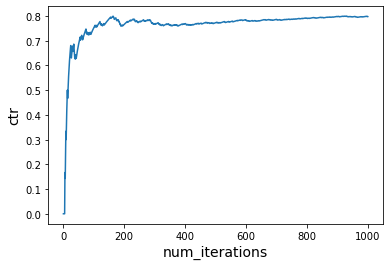

In [18]:
## Test run, when Contextual Bandit is learning
VW = ContextualBandit("--cb_explore_adf -q SA --quiet --epsilon 0.2 --random_seed 123")

ctr_L = run_simulation(VW, num_iterations,actions,User1,seed1,PL)
VW.finish() ## This is important otherwise the learned properties propagates further.
plot_ctr(num_iterations, ctr_L)

100%|███████████████████████████████████████| 1000/1000 [01:40<00:00,  9.96it/s]


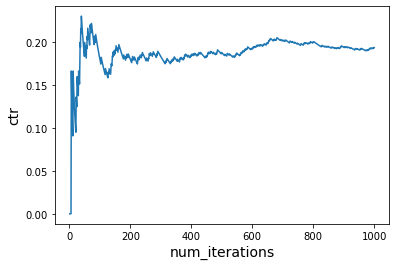

In [20]:
## Test run, when Contextual Bandit is NOT learning

VW = ContextualBandit("--cb_explore_adf -q SA --quiet --epsilon 0.2 --random_seed 123")


ctr_NL = run_simulation(VW, num_iterations,actions,User1,seed1,PL,do_learn=False)
VW.finish()
plot_ctr(num_iterations, ctr_NL)

#### Plot Contextual Bandit algorithm output when the algorithm is learning and when it is not. 
This is one of the ways to compare that the Contextual Bandit alogrithm is learning the underlying dynamics to learn the reward model. It is natural to anticipate that the algorithm that learns will have higher avergae cummulative reward than the one, were we do not learn. In fact, we observe the same in our comparative plot below.

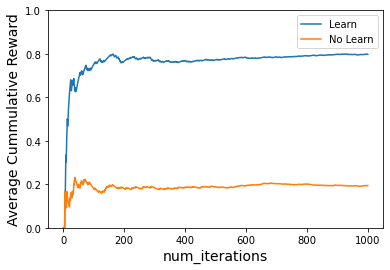

In [52]:

plt.plot(range(1, num_iterations + 1), ctr_L,label='Learn')
plt.plot(range(1, num_iterations + 1), ctr_NL,label='No Learn')
plt.xlabel("num_iterations", fontsize=14)
plt.ylabel("Average Cummulative Reward", fontsize=14)
plt.ylim([0,1.0])
plt.legend()

However, note that the above result is only for a single seed. So, in order to conslude that the differen between the two average cummulative rewards above are significantly different, we replicate the experiment for 30 different seeds and plot each of the average cummulative rewards with 10th and the 90th quantile. 

In [23]:
seeds=range(30)
ctr_LL=[]
ctr_NLL=[]
for seed in seeds:
    VW = ContextualBandit("--cb_explore_adf -q SA --quiet --epsilon 0.2 --random_seed 123")
    ctr_LL.append( run_simulation(VW, num_iterations,actions,User1,seed,PL))
    VW.finish()
    VW = ContextualBandit("--cb_explore_adf -q SA --quiet --epsilon 0.2 --random_seed 123")
    ctr_NLL.append( run_simulation(VW, num_iterations,actions,User1,seed,PL,do_learn=False))
    VW.finish()


100%|███████████████████████████████████████| 1000/1000 [01:37<00:00, 10.21it/s]


##### Average Cummulative reward plots with confidence intervals

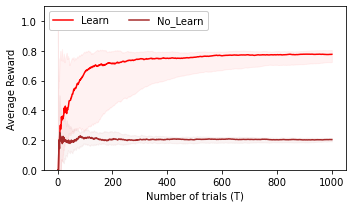

In [32]:
plt.subplots(figsize=(5,3))
color=['red','brown','black','blue','magenta','green','cyan']
plt.plot(range(1, num_iterations + 1), np.median(ctr_LL,axis=0), label='Learn',color=color[0])
plt.fill_between(range(1, num_iterations + 1),np.quantile(ctr_LL,0.1,axis=0), np.quantile(ctr_LL,0.9,axis=0), alpha=0.05, color=color[0])
plt.plot(range(1, num_iterations + 1), np.median(ctr_NLL,axis=0), label='No_Learn',color=color[1])
plt.fill_between(range(1, num_iterations + 1),np.quantile(ctr_NLL,0.1,axis=0), np.quantile(ctr_NLL,0.9,axis=0), alpha=0.05, color=color[1])

plt.legend(ncol=3,loc="upper left",framealpha=1) #bbox_to_anchor=(0.5,1)
# plt.yscale('log')
plt.ylim([0,1.1])
plt.xlabel("Number of trials (T)")
plt.ylabel("Average Reward")
plt.tight_layout()
# plt.savefig('Beta_Ber_Post_Regret'+'.pdf')  
plt.show()

We can conclude from the above plot that the contextual bandit algorithm, where we learn the relationship between features and the reward  observed performs significantly better than the contextual bandit algorithm where we do not. 